# 0. Imports and setup (run all)

In [1]:
# Show the GPU currently in use
!nvidia-smi

Der Befehl "nvidia-smi" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


In [2]:
# Import relevant libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader #TensorDataset, 
from torch.utils.data.sampler import SubsetRandomSampler
import torchsummary
import torchvision
import torchvision.transforms as transforms

from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import time
import numpy as np
import tqdm
import random
from sklearn.model_selection import train_test_split

import sys
import os

In [4]:
# Set device to gpu if available
if torch.cuda.is_available(): 
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# 1. MNIST, CIFAR10 and 20Newsgroups experiments

## 1.1 Model definitions for MNIST, CIFAR10 and 20Newsgroups (run all)

### 1.1.1 VGG11 MNIST

VGGs were introduced in "Very deep convolutional networks for large-scale image recognition", we follow the description in most parts but employ a few small changes due to the changed input dimensions. The most impactful is that the fully connected layers are smaller shrinking the parameter count to 10M down from 130M for the torchvision implementation and speeding up training and inference a lot. We also added optional batch norm. This is enough to fit MNIST well, with our test accuracy being around 99.25% on the full dataset. A description can be seen in torchsummary.


In [5]:
# Model definition
class VGG11(nn.Module):
    def __init__(self, in_channels, num_classes=10, use_bn=False):
        super(VGG11, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes

        # Convolutional ayers
        if use_bn:
            self.conv_layers = nn.Sequential(
                nn.Conv2d(self.in_channels, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(64, 128, kernel_size=3, padding=3),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),
                nn.AvgPool2d(kernel_size=2, stride=2)
                )
        else:
            self.conv_layers = nn.Sequential(
                nn.Conv2d(self.in_channels, 64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(64, 128, kernel_size=3, padding=3),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.AvgPool2d(kernel_size=2, stride=2)
                )
            
        # Fully connected layers
        if use_bn:
            self.linear_layers = nn.Sequential(
            nn.Linear(in_features=512*1*1, out_features=1024), # *7*7
            torch.nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=1024),
            torch.nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=self.num_classes)
            )
        else:
            self.linear_layers = nn.Sequential(
            nn.Linear(in_features=512*1*1, out_features=1024), # *7*7
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=self.num_classes)
            )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [6]:
# Show the shapes and parameter counts for the VGG11 with MNIST input
model = VGG11(1, 10, use_bn=False)
torchsummary.summary(model, (1,28,28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
              ReLU-2           [-1, 64, 28, 28]               0
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 18, 18]          73,856
              ReLU-5          [-1, 128, 18, 18]               0
         MaxPool2d-6            [-1, 128, 9, 9]               0
            Conv2d-7            [-1, 256, 9, 9]         295,168
              ReLU-8            [-1, 256, 9, 9]               0
            Conv2d-9            [-1, 256, 9, 9]         590,080
             ReLU-10            [-1, 256, 9, 9]               0
        MaxPool2d-11            [-1, 256, 4, 4]               0
           Conv2d-12            [-1, 512, 4, 4]       1,180,160
             ReLU-13            [-1, 512, 4, 4]               0
           Conv2d-14            [-1, 51

### 1.1.2 VGG16 CIFAR

Implementation slightly modified from: https://github.com/msyim/VGG16/blob/master/VGG16.py, we particularly do not use adaptive average pooling as that would increase a bottleneck from 512x1x1 to 512x7x7 making the following FC layers much more computationally expensive without adding useful information. To my understanding this layer is only added to give a defined output for different input sizes. This saves 105M of the 138M parameters of the model reducing the model size to 33M. We also ran the original implementation as comparison and it needed around 70% longer to run and had worse performance, probably due to being very overparametrized. We also added optional batch norm.

In [7]:
# Model and layer definitions
def conv_layer(chann_in, chann_out, k_size, p_size, use_bn):
    if use_bn:
      layer = torch.nn.Sequential(
        torch.nn.Conv2d(chann_in, chann_out, kernel_size=k_size, padding=p_size),
        torch.nn.BatchNorm2d(chann_out),
        torch.nn.ReLU(inplace=True))
    else:
      layer = torch.nn.Sequential(
          torch.nn.Conv2d(chann_in, chann_out, kernel_size=k_size, padding=p_size),
          torch.nn.ReLU(inplace=True))
    return layer

def vgg_conv_block(in_list, out_list, k_list, p_list, pooling_k, pooling_s, use_bn):
    layers = [ conv_layer(in_list[i], out_list[i], k_list[i], p_list[i], use_bn) for i in range(len(in_list)) ]
    layers += [ torch.nn.MaxPool2d(kernel_size = pooling_k, stride = pooling_s)]
    return torch.nn.Sequential(*layers)

def vgg_fc_layer(size_in, size_out, use_bn):
    if use_bn:
      layer = torch.nn.Sequential(
          torch.nn.Linear(size_in, size_out),
          torch.nn.BatchNorm1d(size_out),
          torch.nn.ReLU())
    else:
      layer = torch.nn.Sequential(
          torch.nn.Linear(size_in, size_out),
          torch.nn.ReLU())
    return layer

class VGG16(torch.nn.Module):
    def __init__(self, n_classes=10, use_bn=False):
        super(VGG16, self).__init__()

        # Conv blocks
        self.layer1 = vgg_conv_block([3,64], [64,64], [3,3], [1,1], 2, 2, use_bn)
        self.layer2 = vgg_conv_block([64,128], [128,128], [3,3], [1,1], 2, 2, use_bn)
        self.layer3 = vgg_conv_block([128,256,256], [256,256,256], [3,3,3], [1,1,1], 2, 2, use_bn)
        self.layer4 = vgg_conv_block([256,512,512], [512,512,512], [3,3,3], [1,1,1], 2, 2, use_bn)
        self.layer5 = vgg_conv_block([512,512,512], [512,512,512], [3,3,3], [1,1,1], 2, 2, use_bn)

        # FC layers
        self.layer6 = vgg_fc_layer(1*1*512, 4096, use_bn)
        self.layer7 = vgg_fc_layer(4096, 4096, use_bn)

        # Final layer
        self.layer8 = torch.nn.Linear(4096, n_classes)  

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)

        out = out.view(out.size(0), -1)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)

        return out

In [8]:
# Show the shapes and parameter counts for the VGG16 with CIFAR input
model = VGG16(n_classes=10, use_bn=False)
torchsummary.summary(model, (3,32,32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

### 1.1.3 CNN 20NewsGroups

Implementation taken from https://github.com/CSCfi/machine-learning-scripts/blob/master/examples/pytorch_20ng_cnn.py and slightly modified to allow for the option of using batch normalization.

In [9]:
## Model definition
class NEWSMODEL(nn.Module):
    def __init__(self, use_bn=False):
        super(NEWSMODEL, self).__init__()
        self.conv1 = nn.Conv1d(100, 128, 5)
        self.pool1 = nn.MaxPool1d(5)
        self.conv2 = nn.Conv1d(128, 128, 5)
        self.pool2 = nn.MaxPool1d(5)
        self.conv3 = nn.Conv1d(128, 128, 5)
        self.pool3 = nn.MaxPool1d(35)

        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 20)

        self.bn1 = torch.nn.BatchNorm1d(128)
        self.bn2 = torch.nn.BatchNorm1d(128)
        self.bn3 = torch.nn.BatchNorm1d(128)
        self.bn4 = torch.nn.BatchNorm1d(128)

        self.use_bn = use_bn
        
    def forward(self, x):
        x = x.transpose(1,2)

        x = self.conv1(x)
        if self.use_bn: 
            x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        if self.use_bn: 
            x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        if self.use_bn: 
            x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)

        x = x.view(-1, 128)
        x = self.fc1(x)
        if self.use_bn: 
            x = self.bn4(x)
        x = F.relu(x)

        return F.log_softmax(self.fc2(x), dim=1)

In [10]:
# Show the shapes and parameter counts for the 20Newsgroups CNN with input cut to length 1000 with glove embeddings of size 100
model = NEWSMODEL(use_bn=False)
torchsummary.summary(model, (1000,100), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 128, 996]          64,128
         MaxPool1d-2             [-1, 128, 199]               0
            Conv1d-3             [-1, 128, 195]          82,048
         MaxPool1d-4              [-1, 128, 39]               0
            Conv1d-5              [-1, 128, 35]          82,048
         MaxPool1d-6               [-1, 128, 1]               0
            Linear-7                  [-1, 128]          16,512
            Linear-8                   [-1, 20]           2,580
Total params: 247,316
Trainable params: 247,316
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 1.43
Params size (MB): 0.94
Estimated Total Size (MB): 2.76
----------------------------------------------------------------


## 1.2 Dataset load (run all)

### 1.2.1 MNIST

MNIST dataset from Deng, L. (2012). The mnist database of handwritten digit images for machine learning research. IEEE Signal Processing Magazine, 29(6), 141–142.

In [11]:
def load_MNIST(subset="full", BATCH_SIZE=32, classes=10):
    # Preprocessing
    transform = transforms.Compose(
      [transforms.ToTensor(),
        transforms.Normalize(mean=(0.5), std=(0.5))])
    
    # Load Datasets
    train_val_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # Determine train-validation split
    valid_fraction = 1/6
    total_samples = len(train_val_dataset)
    indices = list(range(total_samples))
    split = int((1 - valid_fraction) * total_samples)
    train_idx, valid_idx = indices[:split], indices[split:]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    valid_dataloader = torch.utils.data.DataLoader(train_val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=4, sampler=valid_sampler)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=4)

    # Set dataloaders
    if subset == "full":
        train_dataloader = torch.utils.data.DataLoader(train_val_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=4, sampler=train_sampler)       
    else:
        # Define samples per class, 10 for tiny, 100 for medium
        if subset == "medium":
            samples_per_class = 100
        elif subset == "tiny":
            samples_per_class = 10    

        # Sample through the train-val dataset until the smaller subset is complete
        subset_inputs = torch.zeros(samples_per_class*classes,1,28,28)
        subset_labels = []
        forbidden = []
        for nr, entry in enumerate(train_val_dataset): # we can take the train-val set here as the validation loader takes the last 1/6 of the train-val set and the small subsets are filled long before getting into the last 1/6th.
            inputs, label = entry
            if label in forbidden:
                continue
            else:
                subset_inputs[len(subset_labels)] = inputs
                subset_labels.append(label)
                if sum(np.array(subset_labels) == int(label)) == samples_per_class:
                    forbidden.append(label)
            if len(subset_labels) == (classes * samples_per_class):
                break

        datasubset= torch.utils.data.TensorDataset(subset_inputs, torch.tensor(subset_labels))
        train_dataloader = torch.utils.data.DataLoader(datasubset, batch_size=BATCH_SIZE, shuffle=True)
    return train_dataloader, valid_dataloader, test_dataloader
            

### 1.2.2 CIFAR10

CIFAR10 dataset from Krizhevsky, A., & Hinton, G. (2009). Learning multiple layers of features from tiny images.

In [12]:
def load_CIFAR(subset="full", BATCH_SIZE=256, classes=10):
    # Preprocessisng
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.2, 0.2, 0.2))])
    
    # Load datasets
    train_val_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Determine train-validation split
    valid_fraction = 1/5
    total_samples = len(train_val_dataset)
    indices = list(range(total_samples))
    split = int((1 - valid_fraction) * total_samples)
    train_idx, valid_idx = indices[:split], indices[split:]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # Set dataloaders
    valid_dataloader = torch.utils.data.DataLoader(train_val_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=2, sampler=valid_sampler)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=2)

    # Name classes
    class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    if subset == "full":
        train_dataloader = torch.utils.data.DataLoader(train_val_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=2, sampler=train_sampler)
    elif subset == "tiny":
        # Define samples per class, 100 for tiny
        samples_per_class = 100

        # Sample through the train-val dataset until the smaller subset is complete
        tiny_inputs = torch.zeros(samples_per_class*classes,3,32,32)
        tiny_labels = []
        forbidden = []
        for nr, entry in enumerate(train_val_dataset): # we can take the train-val set here as the validation loader takes the last 1/5 of the train-val set and the small subsets are filled long before getting into the last 1/5th.
            inputs, label = entry
            if label in forbidden:
                continue
            else:
                tiny_inputs[len(tiny_labels)] = inputs
                tiny_labels.append(label)
                if sum(np.array(tiny_labels) == int(label)) == samples_per_class:
                    forbidden.append(label)
            if len(tiny_labels) == (classes * samples_per_class):
                break

        tiny_dataset= torch.utils.data.TensorDataset(tiny_inputs, torch.tensor(tiny_labels))
        train_dataloader = torch.utils.data.DataLoader(tiny_dataset, batch_size=BATCH_SIZE, shuffle=True)
    return train_dataloader, valid_dataloader, test_dataloader

### 1.2.3 20NewsGroups

20Newsgroups dataset from Dua, D. and Graff, C. (2019) UCI Machine Learning Repository. University of California, School of Information and Computer Science, Irvine, CA.
http://archive.ics.uci.edu/ml

Pretrained glove embeddings are used from Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation. [GloVe word embeddings](http://nlp.stanford.edu/projects/glove/)

Implementation copied and modified from https://github.com/CSCfi/machine-learning-scripts/blob/master/examples/pytorch_20ng_cnn.py 


In [13]:
# This part is only for using servers where the information has to be uploaded 
NEWS_DIR = '20newsgroups/'
if False:
  !sudo apt-get install unzip
  !unzip upload
  NEWS_DIR = '20newsgroups/'
  sys.path.append(NEWS_DIR)

In [14]:
 # Define dataset class for later use
class TransformTensorDataset(Dataset):
    def __init__(self, *tensors, embedding_matrix):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors), "Size mismatch between tensors"
        self.tensors = tensors
        self.embed = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)

    def __getitem__(self, index):
        tokens, label = self.tensors[0][index], self.tensors[1][index]
        return self.embed(tokens), label

    def __len__(self):
        return self.tensors[0].size(0)

In [15]:
def load_NEWS(subset="full", BATCH_SIZE=256, classes=20):
    

    ## GloVe word embeddings
    # The datafile contains 100-dimensional embeddings for 400,000 English words.
    print('Indexing word vectors.')
    embeddings_index = {}
    with open('glove.6B.100d.txt', encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Found %s word vectors.' % len(embeddings_index))

    ## 20 Newsgroups data set
    # Next we'll load the [20 Newsgroups] (http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.html)
    #
    # The dataset contains 20000 messages collected from 20 different Usenet newsgroups (1000 messages from each group):
    #
    # | alt.atheism           | soc.religion.christian   | comp.windows.x     | sci.crypt
    # | talk.politics.guns    | comp.sys.ibm.pc.hardware | rec.autos          | sci.electronics
    # | talk.politics.mideast | comp.graphics            | rec.motorcycles    | sci.space
    # | talk.politics.misc    | comp.os.ms-windows.misc  | rec.sport.baseball | sci.med
    # | talk.religion.misc    | comp.sys.mac.hardware    | rec.sport.hockey   | misc.forsale

    TEXT_DATA_DIR = os.path.join("data", "20_newsgroups")
    print('Processing text dataset')
    texts = []  # list of text samples
    labels_index = {}  # dictionary mapping label name to numeric id
    labels = []  # list of label ids
    for name in sorted(os.listdir(TEXT_DATA_DIR)):
        path = os.path.join(TEXT_DATA_DIR, name)
        if os.path.isdir(path):
            label_id = len(labels_index)
            labels_index[name] = label_id
            for fname in sorted(os.listdir(path)):
                if fname.isdigit():
                    fpath = os.path.join(path, fname)
                    args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
                    with open(fpath, **args) as f:
                        t = f.read()
                        i = t.find('\n\n')  # skip header
                        if 0 < i:
                            t = t[i:]
                        texts.append(t)
                    labels.append(label_id)
    print('Found %s texts.' % len(texts))

    # Tokenize the texts using gensim.
    tokens = list()
    for text in texts:
        tokens.append(simple_preprocess(text))

    # Vectorize the text samples into a 2D integer tensor.
    MAX_NUM_WORDS = 10**6 # 2 words reserved: 0=pad, 1=oov        # STARTED AT 10000
    MAX_SEQUENCE_LENGTH = 1000
    dictionary = Dictionary(tokens)
    dictionary.filter_extremes(no_below=0, no_above=1.0, keep_n=MAX_NUM_WORDS-2)
    word_index = dictionary.token2id
    print('Found %s unique tokens.' % len(word_index))
    data = [dictionary.doc2idx(t) for t in tokens]

    # Prepare the embedding matrix:
    print('Preparing embedding matrix.')
    EMBEDDING_DIM = 100
    embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))
    n_not_found = 0
    for word, i in word_index.items():
        if i >= MAX_NUM_WORDS-2:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i+2] = embedding_vector
        else:
            n_not_found += 1
    embedding_matrix = torch.FloatTensor(embedding_matrix)
    print('Shape of embedding matrix:', embedding_matrix.shape)
    print('Words not found in pre-trained embeddings:', n_not_found)

    # Truncate and pad sequences.
    data = [i[:MAX_SEQUENCE_LENGTH] for i in data]
    data = np.array([np.pad(i, (0, MAX_SEQUENCE_LENGTH-len(i)), mode='constant', constant_values=-2) for i in data], dtype=int)
    data = data + 2
    print('Shape of data tensor:', data.shape)
    print('Length of label vector:', len(labels))

    # Split the data into a training set and a validation set
    VALIDATION_SET, TEST_SET = 1000, 4000
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=TEST_SET, shuffle=True, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=VALIDATION_SET, shuffle=False)
    print('Shape of training data tensor:', x_train.shape)
    print('Length of training label vector:', len(y_train))
    print('Shape of validation data tensor:', x_val.shape)
    print('Length of validation label vector:', len(y_val))
    print('Shape of test data tensor:', x_test.shape)
    print('Length of test label vector:', len(y_test))

    # Create PyTorch DataLoaders for all data sets:
    print('Train: ', end="")
    train_dataset = TransformTensorDataset(torch.LongTensor(x_train), torch.LongTensor(y_train), embedding_matrix=embedding_matrix)
    print(len(train_dataset), 'messages')
    print('Validation: ', end="")
    valid_dataset = TransformTensorDataset(torch.LongTensor(x_val), torch.LongTensor(y_val), embedding_matrix=embedding_matrix)
    valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
    print(len(valid_dataset), 'messages')
    print('Test: ', end="")
    test_dataset = TransformTensorDataset(torch.LongTensor(x_test), torch.LongTensor(y_test), embedding_matrix=embedding_matrix)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
    print(len(test_dataset), 'messages')

    # Select subset
    if subset == "full":
        train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    if subset == "tiny":
        samples_per_class = 100

        tiny_inputs = torch.zeros(samples_per_class*classes,1000,100)
        tiny_labels = []
        forbidden = []
        for nr, entry in enumerate(train_dataset):
            inputs, label = entry
            if label in forbidden:
                continue
            else:
                tiny_inputs[len(tiny_labels)] = inputs
                tiny_labels.append(label)
                if sum(np.array(tiny_labels) == int(label)) == samples_per_class:
                    forbidden.append(label)
            if len(tiny_labels) == (classes * samples_per_class):
                break

        tiny_dataset = torch.utils.data.TensorDataset(tiny_inputs, torch.tensor(tiny_labels))
        train_dataloader = torch.utils.data.DataLoader(tiny_dataset, batch_size=BATCH_SIZE, shuffle=True)
    return train_dataloader, valid_dataloader, test_dataloader

## 1.3 Training functions (run all)

In [16]:
# Function returning validation loss and accuracy, can also print out accuracies for each class
# Copied from https://debuggercafe.com/training-vgg11-from-scratch-using-pytorch/

def validate(model, loader, criterion, num_classes, print_class_acc=False):
    model.eval()

    # Two lists for keeping track of class_wise accuracy
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    total_sampled = 0
    with torch.no_grad():
        for counter, data in enumerate(loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            total_sampled += labels.shape[0]

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()

            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

            # Classwise accuracy
            correct  = (preds == labels).squeeze()
            for i in range(len(preds)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / total_sampled)
    print()
    if print_class_acc:
        print('\n')
        for i in range(num_classes):
            print(f"Acc of digit {i}: {100*class_correct[i]/class_total[i]}")
    return epoch_loss, epoch_acc

In [17]:
# This part encompasses the training loop with many more options to test components of ABA or create non-ABA comparisons, like gaussian noise on input, 
# those experiments did not make it into the paper but were valuable in establishing relationships that lead to the major findings

def train_augment(model, train_dataloader, optimizer, settings, adj_set, show_augmentation=False):
    strength = torch.tensor(settings["augmentation_strength"]).to(device)

    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total_samples = 0
    for i, data in enumerate(train_dataloader):
        counter += 1
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Augmentation pipeline
        # Attribution not needed for these types
        if settings["type"] == "none":
            augmented_inputs = inputs
        elif settings["type"] == "noise":
            augmentation = torch.randn(inputs.shape).to(device) * strength
            augmented_inputs = inputs + augmentation

        # Attribution generation step is covered here
        else:
            # Forward pass 
            inputs.requires_grad = True  # This is needed for Vanilla Gradient and Gradient x Input
            outputs = model(inputs)
            batch = outputs.shape[0]

            # Choose attribution target
            if settings["attribution_target"] == "class_wise": 
                top = torch.topk(outputs, settings["k"])
                target_class = random.randint(0, settings["k"]-1)
                torch.sum(top[0][:,target_class]).backward()
            elif settings["attribution_target"] == "class_wise_label": # Here one of the possible class targets is always the label, no matter the model prediction
                copy_outputs = outputs.scatter(1, torch.unsqueeze(labels, 1), -10**3)
                top = torch.topk(copy_outputs, settings["k"]-1)
                target_class = random.randint(0, settings["k"]-1)
                indices = torch.cat((torch.unsqueeze(labels, 1), top[1]), 1)
                possibilities = torch.gather(outputs, 1, indices)
                torch.sum(possibilities[:,target_class]).backward()
            elif settings["attribution_target"] == "loss":
                target_class = None
                loss = nn.CrossEntropyLoss()(outputs, labels)
                loss.backward()

            # Choose attribution method
            if settings["attribution_method"] == "vanilla_gradient":
                attribution = inputs.grad
            elif settings["attribution_method"] == "gradient_x_input":
                attribution = inputs.grad * inputs

            # Shape is remembered as inputs are flattened for ABA and some other non-ABA comparisons
            original_shape = attribution.shape
            attribution = attribution.reshape(batch, -1)

            # Decide if ABA or non-ABA experiments should be used
            if settings["type"] == "ABA":
                augmentation = ABA(attribution, batch, settings, adj_set, target_class)
            else: 
                # Choose cutoff
                if settings["cutoff"]: 
                    abs_in = abs(attribution)
                    if settings["cutoff_direction"] == "extreme":
                        relevant = torch.where(abs_in > (abs_in.mean(dim=1) + abs_in.std(dim=1) * 1).reshape(-1,1), torch.tensor(1.0).to(device), torch.tensor(0.0).to(device))
                    elif settings["cutoff_direction"] == "middle":
                        relevant = torch.where(abs_in < (abs_in.mean(dim=1) + abs_in.std(dim=1) * 1).reshape(-1,1), torch.tensor(1.0).to(device), torch.tensor(0.0).to(device))
                else:
                    relevant = 1

                # Choose augmentation base
                if settings["type"] == "gradient":
                    augmentation =  relevant * attribution
                elif settings["type"] == "grad_normed":
                    augmentation = relevant * torch.nn.functional.normalize(attribution, p=settings["p"], dim=1, eps=1e-12, out=None)

            # Augmentation is calculated
            augmentation = augmentation.reshape(original_shape)
            augmented_inputs = inputs + augmentation * strength         

            # Illustrate augmentation
            if i == 0 and show_augmentation:
                fig, axs = plt.subplots(1,3)
                show_pic = random.randint(0,31)
                axs[0].imshow(inputs[show_pic,0].cpu().detach().numpy())
                axs[1].imshow(augmented_inputs[show_pic,0].cpu().detach().numpy())
                if settings["use_attribution"]:
                    axs[2].hist(attribution[0].cpu().detach().flatten())

        # Regular DL training
        # forward pass
        optimizer.zero_grad()
        outputs = model(augmented_inputs)

        # calculate the loss
        loss = nn.CrossEntropyLoss()(outputs, labels)
        train_running_loss += loss.item()

        # backward pass
        loss.backward()
        optimizer.step()

        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        total_samples += labels.shape[0]

    epoch_loss = train_running_loss / counter
    epoch_acc = 100 * train_running_correct / total_samples
    return epoch_loss, epoch_acc

In [18]:
# ABA methods are applied here (everything but the attribution generation step)
def ABA(attribution, batch, settings, adj_set, target_class):
    variant = settings["ABA_variant"] 
    
    # Attribution Selection Step
    if variant == "fast":
        cutoffs = [0,0]
    if variant == "challenger" or variant == "mend":
        cutoff_percentiles = torch.tensor(settings["percentiles"]).to(device)        # value smaller than cutoff, value higher than cutoff
        cutoffs = torch.quantile(attribution, cutoff_percentiles, dim=1, keepdim=True)

    # Determine relevant features, implementation is optimized so middle features never have to be determined seperately
    smallest = torch.where(attribution < cutoffs[0], torch.tensor(1.0).to(device), torch.tensor(0.0).to(device))
    highest = torch.where(attribution > cutoffs[1], torch.tensor(1.0).to(device), torch.tensor(0.0).to(device))

    # Pick random adjustments from the adjustment set
    module = torch.randint(0, len(adj_set), (batch,1)) * torch.ones((1,3), dtype=int)
    mults = torch.gather(adj_set, 0, module).to(device)

    # Augmentation Step
    # To ensure consistency between delta and epsilon, loss and class scores have to have reversed adjustment assignments (negative attribution for loss means positive for label class score eg)
    if settings["attribution_target"] == "loss":
        selection = mults[:,1].reshape(batch,1) * smallest + mults[:,2].reshape(batch,1) * highest + mults[:,0].reshape(batch,1)
    elif settings["attribution_target"] == "class_wise":
        selection = mults[:,2].reshape(batch,1) * smallest + mults[:,1].reshape(batch,1) * highest + mults[:,0].reshape(batch,1)
    elif settings["attribution_target"] == "class_wise_label":
        if target == 0:
            selection = mults[:,2].reshape(batch,1) * smallest + mults[:,1].reshape(batch,1) * highest + mults[:,0].reshape(batch,1)
        else:
            selection = mults[:,1].reshape(batch,1) * smallest + mults[:,2].reshape(batch,1) * highest + mults[:,0].reshape(batch,1)

    if variant == "fast" or variant == "mend":
        selection *= abs(torch.randn((batch,1)).to(device))

    # The attribution guided dropout needs modifications in other parts of the pipeline
    #if settings["guided_dropout"]:
    #    keep = torch.ones_like(attribution) * settings["guided_dropout"]
    #    selection *= torch.bernoulli(keep)

    return selection

In [19]:
# Run all experiments for the list of settings
def run_experiments(settings_list, adjustment_sets, SAVE_PATH="model_checkpoints"):

    # All adjustment possibilities for the 3 category case like in table 3.1 but with the more efficient implementation from Appendix Table A.1
    possible_adjustments = [[0,0,0],
                            [1,-1,-1],[-1,1,1],[0,0,1],[0,0,-1],[0,1,0],[0,-1,0],
                            [1,-1,0],[-1,1,2],[1,-1,-2],[-1,1,0],[1,0,-1],[-1,2,1],[1,-2,-1],[-1,0,1],[0,1,1],[0,1,-1],[0,-1,1],[0,-1,-1],
                            [1,0,0],[-1,2,2],[1,0,-2],[-1,2,0],[1,-2,0],[-1,0,2],[1,-2,-2],[-1,0,0]]

    # Iterate through all adjustment_sets
    val_results = []
    test_results = []
    for indexes_adjustment_set in adjustment_sets:
        adjustment_set = torch.tensor([possible_adjustments[ind] for ind in indexes_adjustment_set]) 
        
        # Iterate through other settings
        adjustment_val_results = []
        adjustment_test_results = []
        for settings in settings_list:

            # Get the correct dataloaders
            dataset = settings["dataset"]
            if dataset == "mnist":
                train_dataloader, valid_dataloader, test_dataloader = load_MNIST(subset=settings["subset"])
            elif dataset == "cifar":
                train_dataloader, valid_dataloader, test_dataloader = load_CIFAR(subset=settings["subset"])
            elif dataset == "news":
                train_dataloader, valid_dataloader, test_dataloader = load_NEWS(subset=settings["subset"])

            epochs = settings["epochs"]
            show_augmentation = False #settings["show_augmentation"]
            use_bn = settings["use_batchnorm"]

            print("Settings: ", settings)

            # Iterate through runs
            val_setting_results = []
            test_setting_results = []
            for training_run in range(settings["repetitions"]):
                val_run_results = []
                val_acc_max = 0

                # Instantiate the model and optimizer
                if dataset == "mnist" or dataset == "cifar":             
                    num_classes = 10
                    if use_bn: 
                        lr = 0.0005
                    else: 
                        lr = 0.0001
                    if dataset == "mnist": 
                        model = VGG11(in_channels=1, num_classes=10, use_bn=use_bn).to(device)
                    elif dataset == "cifar": 
                        model = VGG16(n_classes=10, use_bn=use_bn).to(device)
                    optimizer = optim.Adam(model.parameters(), lr=lr) 
                elif dataset == "news":
                    num_classes = 20
                    model = NEWSMODEL(use_bn=use_bn).to(device)
                    lr = 0.005
                optimizer = optim.Adam(model.parameters(), lr=lr) 

                # Training
                print("Training Run = " + str(training_run + 1))
                train_loss, valid_loss = [], []
                train_acc, valid_acc = [], []
                for epoch in tqdm.tqdm(range(epochs)):
                    train_epoch_loss, train_epoch_acc = train_augment(model, train_dataloader, optimizer, settings, adjustment_set, show_augmentation) #tiny_train_dataloader
                    train_loss.append(train_epoch_loss)
                    train_acc.append(train_epoch_acc)

                    show_augmentation = False
                    if (epoch+1) % (epochs//settings["validate_total"]) == 0:
                        print()
                        show_augmentation = False #settings["show_augmentation"]
                        valid_epoch_loss, valid_epoch_acc = validate(model, valid_dataloader, nn.CrossEntropyLoss(), num_classes, print_class_acc=False)
                        valid_loss.append(valid_epoch_loss)
                        valid_acc.append(valid_epoch_acc)
                        print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
                        print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
                        print('-'*50)
                        val_run_results.append([valid_epoch_loss, valid_epoch_acc])

                        # Save model with highest validation_accuracy in the run
                        if valid_epoch_acc > val_acc_max:
                            checkpoint = {'epoch': epoch, 'model_state': model.state_dict()}
                            torch.save(checkpoint, SAVE_PATH)
                            val_acc_max = valid_epoch_acc

                # End of run model
                val_setting_results.append(val_run_results)

                # Best val-acc model is used for testing 
                if dataset == "mnist":
                    model = VGG11(in_channels=1, num_classes=10, use_bn=use_bn).to(device)
                elif dataset == "cifar":
                    model = VGG16(n_classes=10, use_bn=use_bn).to(device)
                elif dataset == "news":
                    model = NEWSMODEL(use_bn=use_bn).to(device)
                checkpoint = torch.load(SAVE_PATH)
                model.load_state_dict(checkpoint['model_state'])
                model.to(device)
                model.eval()
                test_loss, test_acc = validate(model, test_dataloader,  nn.CrossEntropyLoss(), num_classes, print_class_acc=False)
                test_setting_results.append([test_loss, test_acc])

            adjustment_val_results.append(val_setting_results)
            adjustment_test_results.append(test_setting_results)
        val_results.append(adjustment_val_results)
        test_results.append(adjustment_test_results)
    return val_results, test_results, 

## 1.4 Adjustments and adjustment set experiments

    A settings description is given here:
    1. dataset - string - (mnist, cifar, news)
    2. subset - string - (full, tiny, medium)
    3. repetitions - int
    4. epochs - int 
    5. validate_total - int -> How often the validation loss is calculated
    6. use_batchnorm - bool 

    7. type - string - (none, noise, ABA...) -> there are many non-ABA experiments implemented, with own settings, but they are not too relevant here
    8. attribution_method - string - (vanilla_gradient, gradient_x_input)
    9. attribution_target - string - (loss, class_wise, class_wise_label)
    9.1. k - int -> relevant when a class score needs to be randomly selected

    10. augmentation_strength - float
    11. ABA_variant - string - (challenger, mend, fast)
    11.1 percentiles - list of floats - (between 0 and 1, low to high)



In [20]:
# Some premade adjustment sets (in the index variant)
challenger = [0,0,0,0,3,4,5,6]
mend = [1,2,3,4,5,6]
fast = [0,0,3,4,5,6,16,17]

delta = [4,5,9,10,11,12,16,21,22]
epsilon = [3,6,7,8,13,14,17,23,24]
neutral = [0,1,2,15,18,19,20,25,26]
zeros = [0,0,0,0,0,0,0,0]

# Pass adjustment_sets as list
adjustment_sets = [challenger]

# Pass other settings as dictionary:
settings_list = [
            {"dataset": "mnist",                           
             "subset": "tiny",                              
             "repetitions": 1,
             "epochs": 1000,        
             "use_batchnorm": False,  
             "validate_total": 1, 
             
             "attribution_method": "vanilla_gradient",
             "attribution_target": "class_wise", 
             "k":4,
             "augmentation_strength": 1,

             "type": "ABA",
             "ABA_variant": "fast", 
             "percentiles": [0.1, 0.9],
            },

        ]

# Iterate through adjustment_sets, other settings and repetitions
val_results, test_results = run_experiments(settings_list, adjustment_sets)

Settings:  {'dataset': 'mnist', 'subset': 'tiny', 'repetitions': 1, 'epochs': 1000, 'use_batchnorm': False, 'validate_total': 1, 'attribution_method': 'vanilla_gradient', 'attribution_target': 'class_wise', 'k': 4, 'augmentation_strength': 1, 'type': 'ABA', 'ABA_variant': 'fast', 'percentiles': [0.1, 0.9]}
Training Run = 1


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [45:59<00:02,  2.98s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [46:34<00:00,  2.79s/it]


Training loss: 0.005, training acc: 100.000
Validation loss: 0.877, validation acc: 86.610
--------------------------------------------------
Validation


In [21]:
# Either show validation or test set results
val = False

for i in range(len(adjustment_sets)):
    v = val_results[i]
    t = test_results[i]
    print("Results for the adjustment set " + str(i+1) + ":\n")
    if val:
        accs = np.array(v)[:,:,:,1]
        max_accs = np.max(accs, axis=2)
    else:
        max_accs = np.array(t)[:,:,1]
    total_median = np.median(max_accs, axis=1)
    total_max = np.max(max_accs, axis=1)
    total_std = np.std(max_accs, axis=1)
    print("Best accuracy of each repetition:", max_accs, "\n", 
          "Highest accuracy of all repetitions:", total_max, "\n",
          "Standard deviation of accuracy between repetitions (best):", total_std, "\n",
          "Median accuracy of accuracy between repetitions (best):", total_median, "\n\n")

Results for the adjustment set 1:

Best accuracy of each repetition: [[85.53]] 
 Highest accuracy of all repetitions: [85.53] 
 Standard deviation of accuracy between repetitions (best): [0.] 
 Median accuracy of accuracy between repetitions (best): [85.53] 




## 1.5 Delta and Epsilon in evaluation experiments

This was used for generating Figure 3.2, where the model is frozen and Delta and Epsilon adjustments are used on input features

In [101]:
def validate_frozen(model, loader, criterion, change, printt=True):
    model.eval()
    valid_running_loss = 0.0
    valid_running_correct = 0
    postchange_running_loss = 0.0
    postchange_running_correct = 0
    total_sampled = 0

    for counter, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        total_sampled += labels.shape[0]
        inputs.requires_grad = True

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        valid_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        valid_running_correct += (preds == labels).sum().item()

        batch = inputs.shape[0]
        loss.backward()
        attribution = inputs.grad
        attribution = attribution.reshape(batch, -1)
        high_low = torch.randint(0,2,(batch,1)).to(device)
        cutoff_quantiles = torch.tensor([0.1, 0.9]).to(device)        # value smaller than cutoff, value higher than cutoff
        cutoffs = torch.quantile(attribution, cutoff_quantiles, dim=1, keepdim=True)
        smallest = torch.where(attribution < cutoffs[0], torch.tensor(1.0).to(device), torch.tensor(0.0).to(device))
        highest = torch.where(attribution > cutoffs[1], torch.tensor(1.0).to(device), torch.tensor(0.0).to(device))

        select_smallest = smallest * (high_low == 0)
        select_highest = highest * (high_low == 1)

        input_change = (change * (-1 * select_smallest + +1 * select_highest)).reshape(inputs.shape)
        new_inputs = inputs + input_change
        outputs = model(new_inputs)
        loss = criterion(outputs, labels)
        postchange_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        postchange_running_correct += (preds == labels).sum().item()

    valid_loss = valid_running_loss / counter
    valid_acc = 100. * (valid_running_correct / total_sampled)

    postchange_loss = postchange_running_loss / counter
    postchange_acc = 100. * (postchange_running_correct / total_sampled)
    print()

    return valid_loss, valid_acc, postchange_loss, postchange_acc

In [126]:
dataset = "mnist"
subset = "tiny"
use_bn = False

# Load model from previous training 
if dataset == "mnist":
    model = VGG11(in_channels=1, num_classes=10, use_bn=use_bn).to(device)
elif dataset == "cifar":
    model = VGG16(n_classes=10, use_bn=use_bn).to(device)
elif dataset == "news":
    model = NEWSMODEL(use_bn=use_bn).to(device)
checkpoint = torch.load("model_checkpoints")
model.load_state_dict(checkpoint['model_state'])
model.to(device)

if dataset == "mnist":
    train_dataloader, valid_dataloader, test_dataloader = load_MNIST(subset=subset)
elif dataset == "cifar":
    train_dataloader, valid_dataloader, test_dataloader = load_CIFAR(subset=subset)
elif dataset == "news":
    train_dataloader, valid_dataloader, test_dataloader = load_NEWS(subset=subset)

losses, accs = [], []
for change in [0.2*p for p in range(-15,16)]:
  model.eval()
  valid_loss, valid_acc, postchange_loss, postchange_acc = validate_frozen(model, valid_dataloader, nn.CrossEntropyLoss(), change=change, printt=False)
  print(postchange_loss, postchange_acc)
  losses.append(postchange_loss)
  accs.append(postchange_acc)


0.7308559500110837 86.37

0.6881406017077657 87.01

0.673557309851719 87.42999999999999

0.6657044527796993 87.92

0.6248775645314405 88.97

0.5808169634636635 89.82

0.5283188905915057 90.64

0.47342841923818924 91.67

0.39217155236931434 92.83

0.3162787276322398 93.88

0.2504417536419612 94.72

0.2093761906544387 95.43

0.19813695877840076 95.46

0.22954411497639973 94.54

0.35899715906923985 92.24

0.7342646060935341 86.95

1.4208248966397383 77.85

2.2565001975267363 68.47999999999999

3.106984026921101 60.22

3.954051596614031 51.83

4.685502526851801 44.42

5.3157489735346575 37.580000000000005

5.818114769000274 31.69

6.148424905844224 26.69

6.292027801275253 22.67

6.394597311050464 19.86

6.417432979895518 17.49

6.456984623884543 16.25

6.378112337528131 15.58

6.26876745850612 15.040000000000001

6.2920049749887905 14.87


Text(0, 0.5, 'Validation Accuracy')

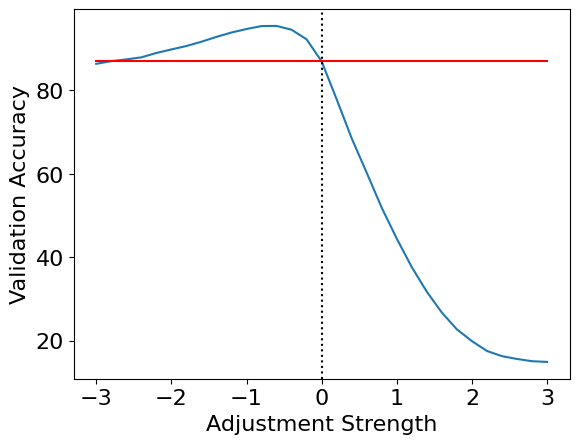

In [128]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update({'font.size': 16})

x = [0.2*p for p in range(-15,16)]
y = accs
y2 = [y[15] for p in range(31)]
plt.figure()
plt.plot(x,y)
plt.plot(x,y2,"r-")
plt.axvline(x = 0, color = 'black', label = 'axvline - full height', linestyle="dotted")
plt.xlabel('Adjustment Strength')
plt.ylabel('Validation Accuracy')

## 1.6 Adjustment illustration

In [24]:
# Illustrate categories in attribution selection step for MNIST and vanilla gradient
def illustrate(model, train_dataloader, adj_set, strength=1):
    # All adjustment possibilities for the 3 category case like in table 3.1 but with the more efficient implementation from Appendix Table A.1
    possible_adjustments = [[0,0,0],
                            [1,-1,-1],[-1,1,1],[0,0,1],[0,0,-1],[0,1,0],[0,-1,0],
                            [1,-1,0],[-1,1,2],[1,-1,-2],[-1,1,0],[1,0,-1],[-1,2,1],[1,-2,-1],[-1,0,1],[0,1,1],[0,1,-1],[0,-1,1],[0,-1,-1],
                            [1,0,0],[-1,2,2],[1,0,-2],[-1,2,0],[1,-2,0],[-1,0,2],[1,-2,-2],[-1,0,0]]

    adj_set = torch.tensor([possible_adjustments[ind] for ind in adj_set]) 

    model.train()
    for i, data in enumerate(train_dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Attribution generation step is covered here
        # Forward pass 
        inputs.requires_grad = True  # This is needed for Vanilla Gradient and Gradient x Input
        outputs = model(inputs)
        batch = outputs.shape[0]

        # Backward pass
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()

        # Attribution for vanilla gradient
        attribution = inputs.grad
        original_shape = attribution.shape
        attribution = attribution.reshape(batch, -1)

        cutoff_percentiles = torch.tensor([0.1, 0.9]).to(device)        # value smaller than cutoff, value higher than cutoff
        cutoffs = torch.quantile(attribution, cutoff_percentiles, dim=1, keepdim=True)

        # Determine relevant features, implementation is optimized so middle features never have to be determined seperately
        smallest = torch.where(attribution < cutoffs[0], torch.tensor(1.0).to(device), torch.tensor(0.0).to(device))
        highest = torch.where(attribution > cutoffs[1], torch.tensor(1.0).to(device), torch.tensor(0.0).to(device))
        medium = torch.where(smallest + highest == 0, 1, 0)

        illustration_categories = torch.cat([smallest.reshape(original_shape), medium.reshape(original_shape), highest.reshape(original_shape)], dim=1)    

        # Pick random adjustments from the adjustment set
        module = torch.randint(0, len(adj_set), (batch,1)) * torch.ones((1,3), dtype=int)
        mults = torch.gather(adj_set, 0, module).to(device)
    
        # Augmentation Step
        # To ensure consistency between delta and epsilon, loss and class scores have to have reversed adjustment assignments (negative attribution for loss means positive for label class score eg)
        augmentation = mults[:,1].reshape(batch,1) * smallest + mults[:,2].reshape(batch,1) * highest + mults[:,0].reshape(batch,1)
        
        # Augmentation is calculated
        augmentation = augmentation.reshape(original_shape)
        augmented_inputs = inputs + augmentation * strength         

        # Illustrate augmentation
        print(illustration_categories.shape, inputs.shape, augmented_inputs.shape)
        for i in range(10):
            plt.figure()
            plt.subplot(1, 3, 1)
            plt.imshow(illustration_categories[i].cpu().numpy().transpose(1, 2, 0))
            plt.subplot(1, 3, 2)
            plt.imshow(inputs[i].detach().cpu().numpy().transpose(1, 2, 0).squeeze())
            plt.subplot(1, 3, 3)
            plt.imshow(augmented_inputs[i].detach().cpu().numpy().transpose(1, 2, 0).squeeze())
            plt.show()
        break

torch.Size([32, 3, 28, 28]) torch.Size([32, 1, 28, 28]) torch.Size([32, 1, 28, 28])


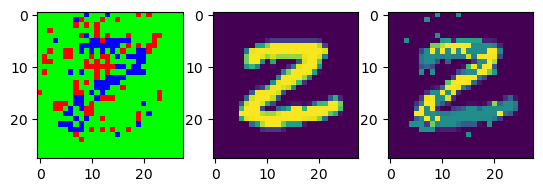

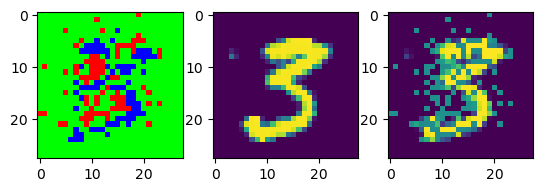

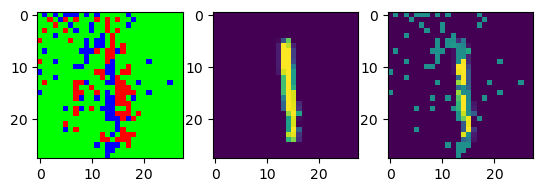

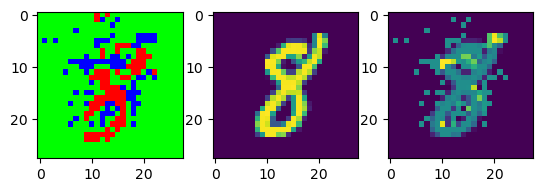

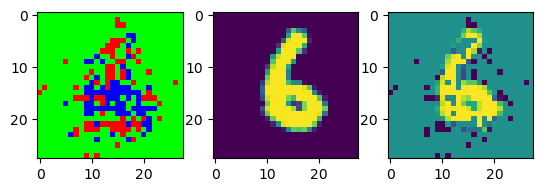

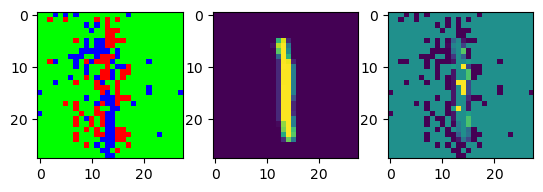

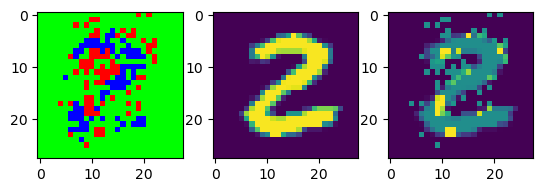

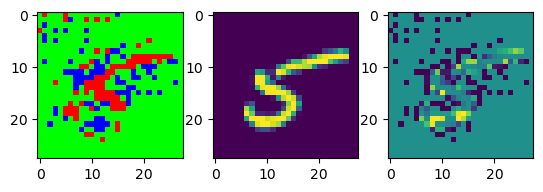

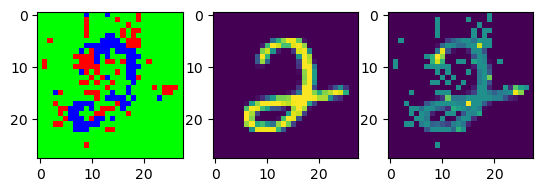

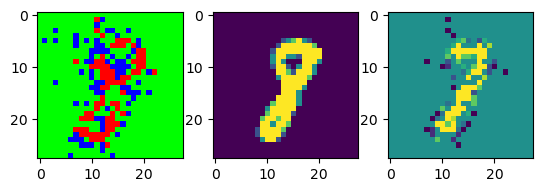

In [25]:
%matplotlib inline
dataset = "mnist"
subset = "tiny"
use_bn = False

# Load model from previous training 
if dataset == "mnist":
    model = VGG11(in_channels=1, num_classes=10, use_bn=use_bn).to(device)
elif dataset == "cifar":
    model = VGG16(n_classes=10, use_bn=use_bn).to(device)
elif dataset == "news":
    model = NEWSMODEL(use_bn=use_bn).to(device)
checkpoint = torch.load("model_checkpoints")
model.load_state_dict(checkpoint['model_state'])
model.to(device)

if dataset == "mnist":
    train_dataloader, valid_dataloader, test_dataloader = load_MNIST(subset=subset)
elif dataset == "cifar":
    train_dataloader, valid_dataloader, test_dataloader = load_CIFAR(subset=subset)
elif dataset == "news":
    train_dataloader, valid_dataloader, test_dataloader = load_NEWS(subset=subset)

adj_set = mend
illustrate(model, train_dataloader, adj_set, strength=2)

# 2. PTB-XL

Implementation taken and modified from https://github.com/helme/ecg_ptbxl_benchmarking,
PTB-XL published in 

N. Strodthoff, P. Wagner, T. Schaeffter and W. Samek, "Deep Learning for ECG Analysis: Benchmarks and Insights from PTB-XL," in IEEE Journal of Biomedical and Health Informatics, vol. 25, no. 5, pp. 1519-1528, May 2021, doi: 10.1109/JBHI.2020.3022989.

The way that settings are fed in is bothersome:

One needs to access "ptbxl_code\code\models\fastai_models.py" and change the settings in the ABA function in line 525.
I tried to find workarounds to pass the settings in the notebook but could not do it without fastai breaking.

In [4]:
# This part is only for using servers where the data and code has to be uploaded 
if False:
    !sudo apt-get install unzip
    !unzip ptb-xl
    !unzip ptbxl_code

In [5]:
PROJECT_DIR = 'ptbxl_code/code'
sys.path.append(PROJECT_DIR)

from experiments.scp_experiment import SCP_Experiment
from utils import utils
from configs.fastai_configs import *
from configs.wavelet_configs import *

datafolder = 'data/ptbxl/'
datafolder_icbeb = 'data/ICBEB/'
outputfolder = 'ptbxl_code/output/'

models = [
    conf_fastai_fcn_wang
    ] 

##########################################
# STANDARD SCP EXPERIMENTS ON PTBXL
##########################################

experiments = [
    ('exp0', 'all'),
    #('exp1', 'diagnostic'),
    #('exp1.1', 'subdiagnostic'),
    #('exp1.1.1', 'superdiagnostic'),
    #('exp2', 'form'),
    #('exp3', 'rhythm')
    ]

for _ in range(1):
    for name, task in experiments:
        e = SCP_Experiment(name, task, datafolder, outputfolder, models)
        e.prepare()
        e.perform()
        e.evaluate()

        # generate greate summary table
        utils.generate_ptbxl_summary_table(selection=["fastai_fcn_wang"], folder="ptbxl_code/output/")

Training from scratch...
model: fastai_fcn_wang


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,time
0,0.777291,0.603343,03:33
1,0.451552,0.237421,03:38


KeyboardInterrupt: 